# Data Engineer tasks

- [Пример установки дополнительных библиотек](#bullet-1)
- [Подключение линтера](#bullet-2)
- [Пример подключения к базе](#bullet-3)
- [1. Последняя запись ](#bullet-4)
- [2. Продажи и поставки](#bullet-5)
- [3. Товарооборот](#bullet-6)

## Пример установки дополнительных библиотек <a class="anchor" id="bullet-1"></a>

Просто `!pip install module-you-need`

In [1]:
!pip install matplotlib

## Подключение линтера <a class="anchor" id="bullet-2"></a>

In [1]:
%load_ext pycodestyle_magic
%flake8_on

---

In [2]:
import os

import numpy as np

import pandas as pd

import psycopg2

## Пример подключения к базе <a class="anchor" id="bullet-3"></a>

In [3]:
POSTGRES = dict(
    host=os.environ['POSTGRES_HOST'],
    port=int(os.environ['POSTGRES_PORT']),
    dbname=os.environ['POSTGRES_DB'],
    user=os.environ['POSTGRES_USER'],
    password=os.environ['POSTGRES_PASSWORD']
)

In [4]:
conn = psycopg2.connect(**POSTGRES)

try:
    df = pd.read_sql('select * from hello;', conn)
except Exception as ex:
    print(f"Something is wrong: {ex}")
finally:
    conn.close()

In [5]:
df

,short,long
0,Hi,Helloooou


## 1. Последняя запись <a class="anchor" id="bullet-4"></a>

Есть таблица `stocks`, где хранится запас товара в магазине в некоторый момент времени.

**product** | stock | **ts**
:-- | :-- | :--
Швабра | 15 | 2021-07-28 08:00:00
Швабра | 14 | 2021-07-28 09:15:00
Перфоратор | 2 | 2021-07-28 11:30:00
... | ... | ...
Швабра | 3 | 2021-07-29 19:13:00

**product** - наименование товара;  
**stock** - запас товара;  
**ts** - момент, в который запас принял текущее значение;

Первичный ключ: `(product, ts)`

### Задача

Методами языка SQL и(или) Python нужно найти последнее состояние запаса для каждого из товаров.

В результате выполнения запроса должен получиться датасет со следующими колонками:

- **product** - наименование товара;
- **stock** - последнее состояние запаса;
- **ts** - момент, в который запас принял указанное значение;

### Твой запрос

In [6]:
query = """ select stocks1.product,
                  stocks.stock,
                  stocks1.ts
                  
           from (select product,
                        max(ts) as ts   
                 from stocks group by product) as stocks1
           left join stocks on stocks.product=stocks1.product and stocks.ts=stocks1.ts
           order by 2 desc,1         
            
            
"""
# 

4:1: W293 blank line contains whitespace
6:38: W291 trailing whitespace
8:80: E501 line too long (86 > 79 characters)
9:29: W291 trailing whitespace
10:1: W293 blank line contains whitespace
11:1: W293 blank line contains whitespace
13:2: W291 trailing whitespace
13:2: W291 trailing whitespace
13:2: W291 trailing whitespace


### Получение данных

In [7]:
conn = psycopg2.connect(**POSTGRES)

try:
    df = pd.read_sql(query, conn)
except Exception as ex:
    print(f"Something is wrong: {ex}")
finally:
    conn.close()

In [8]:
df

,product,stock,ts
0,Лампочка,291.0,2021-07-25 21:34:00
1,Шпатель,173.0,2021-07-25 19:56:00
2,Отвертка,161.0,2021-07-25 21:56:00
3,Люстра,159.0,2021-07-25 18:26:00
4,Газонокосилка,147.0,2021-07-25 20:04:00
5,Перфоратор,127.0,2021-07-25 21:44:00
6,Камин,7.0,2021-07-25 19:27:00
7,Швабра,0.0,2021-07-25 21:21:00


## 2. Продажи и поставки <a class="anchor" id="bullet-5"></a>

Добавим таблицу `products`, содержащую данные о стоимости товаров:

**product** | price
:-- | :--
Швабра | 1500
... | ...
Люстра | 2000

**product** - наименование товара, первичный ключ;  
**price** - цена продажи в рублях;

Будем рассматривать два основных типа изменения запаса товара:
- **Продажа** - запас уменьшился по сравнению с предыдущим значением, потому что-то купил товар
- **Поставка** - запас увеличился по сравнению с предыдущим значением

### Задача

Методами языка SQL и(или) Python на основе дынных таблицы `stocks` нужно найти суммарные дневные продажи и поставки за каждый день (в штуках и в деньгах).

В результате выполнения запроса должен получиться датасет со следующими колонками:

- **dt** - дата;
- **product** - наименование товара;
- **action_type** - тип изменения запаса: 'SALE', если продажа, 'DELIVERY', если поставка;
- **qty** - продажи товара в штуках в указанную дату;
- **turnover** - продажи товара в деньгах в указанную дату;

### Твой запрос

In [9]:
query = """select 
        s.product,
        s.stock,
        s.ts,
        price
        from stocks s
        join products pr on s.product = pr.product
        order by ts
"""
# 1- Объеденили таблицы

1:10: W291 trailing whitespace


### Получение данных

In [10]:
conn = psycopg2.connect(**POSTGRES)

try:
    df = pd.read_sql(query, conn, index_col=['ts'], parse_dates=['ts']) # вместо индексов создадим временной ряд
except Exception as ex:
    print(f"Something is wrong: {ex}")
finally:
    conn.close()

4:72: E261 at least two spaces before inline comment
4:80: E501 line too long (112 > 79 characters)


In [11]:
df

,product,stock,price
ts,,,
2021-07-19 08:00:00,Люстра,22.0,2000.0
2021-07-19 08:00:00,Лампочка,28.0,200.0
2021-07-19 08:00:00,Газонокосилка,35.0,18000.0
2021-07-19 08:00:00,Камин,9.0,20000.0
2021-07-19 08:00:00,Перфоратор,51.0,7000.0
...,...,...,...
2021-07-25 20:32:00,Лампочка,295.0,200.0
2021-07-25 21:21:00,Швабра,0.0,1500.0
2021-07-25 21:34:00,Лампочка,291.0,200.0


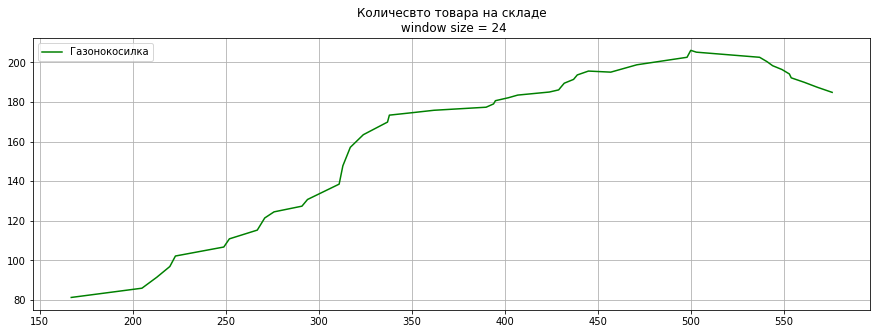

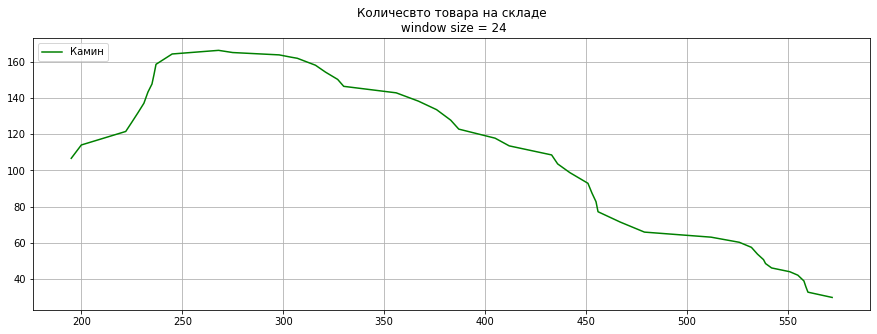

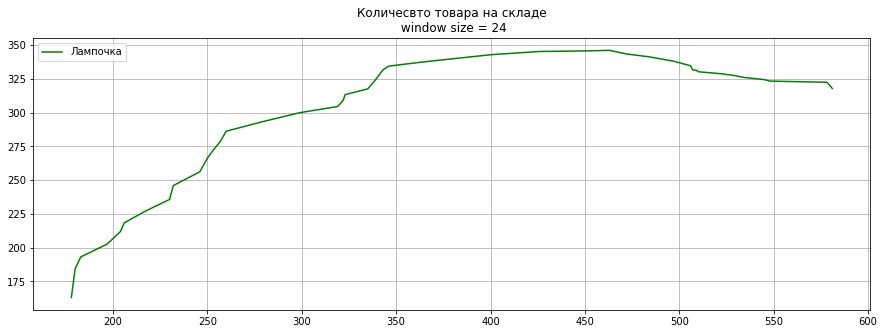

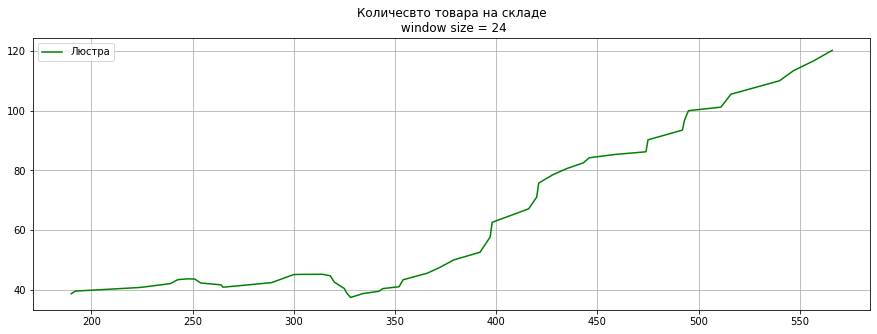

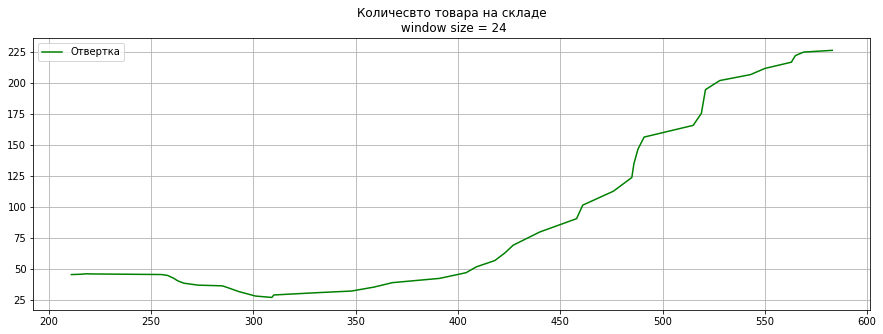

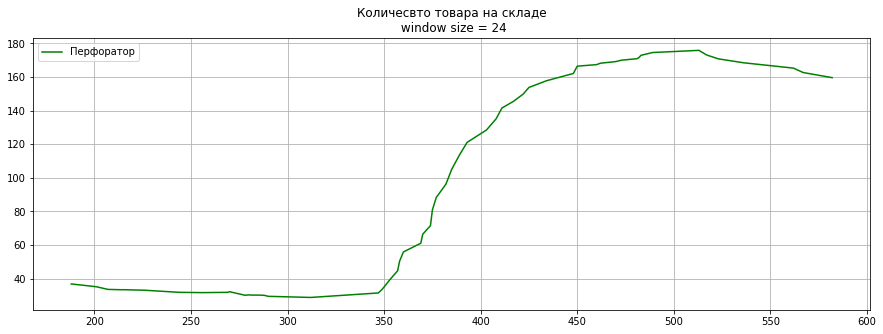

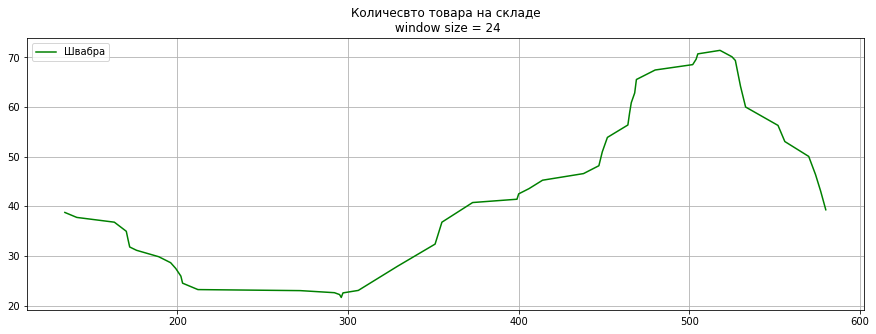

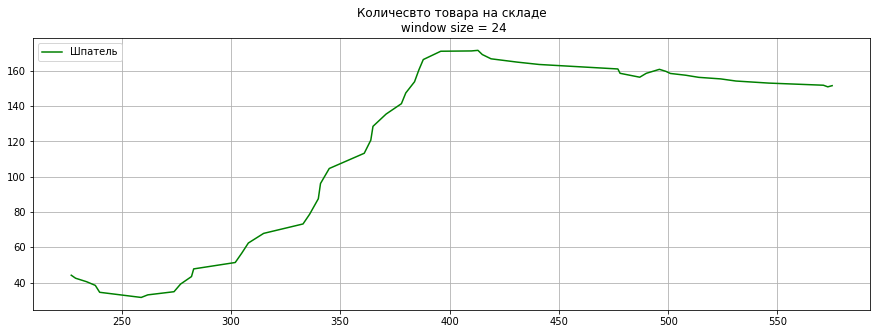

9:1: E302 expected 2 blank lines, found 1
13:28: W291 trailing whitespace
18:1: W293 blank line contains whitespace
20:5: E303 too many blank lines (2)
20:27: E231 missing whitespace after ','
25:1: E305 expected 2 blank lines after class or function definition, found 0
25:55: E261 at least two spaces before inline comment
25:80: E501 line too long (81 > 79 characters)
29:35: E261 at least two spaces before inline comment


In [84]:
"""Сформируем графики наличие товара на складе"""
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import matplotlib.pyplot as plt
import numpy as np

dataset = df[df["product"] == "Люстра"]

def plotMovingAverage(series, col, n=1):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()
    

    plt.figure(figsize=(15,5))
    plt.title("Количесвто товара на складе\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label=col)
    plt.legend(loc="upper left")
    plt.grid(True)
list_product = list(df.groupby('product').max().index) # формируем список product
for col in list_product:
    sf = df[df["product"] == col].stock
    pd.DataFrame({"ts": sf.index, "product": sf.values})
    plotMovingAverage(sf, col, 24) # сглаживаем по дням

In [81]:
query = """with tbl_1 as(
        with tbl as (
        select 
        s.product,
        s.stock,
        s.ts,
        price
        from stocks s
        join products pr on s.product = pr.product
        order by ts
        )
        select tbl.*,
        tbl.stock - lag(tbl.stock) over(order by product) as qty
        from tbl)
        select tbl_1.*, 
        case when (tbl_1.qty < 0) then tbl_1.qty*price*(-1) 
        else 0 end as turnover,
        case when (tbl_1.qty < 0) then 'SALE'
        else 'DELIVERY' end as action_type
        from tbl_1
        order by ts     
        
   -- объединяем таблицы
   -- при помощи оконной фунции группируем и находим разницу между строками stock
   -- из полученной таблицы формируем столбцы turnover	action_type
"""

3:15: W291 trailing whitespace
15:24: W291 trailing whitespace
16:60: W291 trailing whitespace
21:20: W291 trailing whitespace
22:1: W293 blank line contains whitespace
24:27: W291 trailing whitespace
25:80: E501 line too long (652 > 79 characters)


In [82]:
conn = psycopg2.connect(**POSTGRES)

try:
    df = pd.read_sql(query, conn)
except Exception as ex:
    print(f"Something is wrong: {ex}")
finally:
    conn.close()

In [83]:
df

,product,stock,ts,price,qty,turnover,action_type
0,Люстра,22.0,2021-07-19 08:00:00,2000.0,-325.0,650000.0,SALE
1,Шпатель,57.0,2021-07-19 08:00:00,300.0,-123.0,36900.0,SALE
2,Лампочка,28.0,2021-07-19 08:00:00,200.0,-207.0,41400.0,SALE
3,Газонокосилка,35.0,2021-07-19 08:00:00,18000.0,-187.0,3366000.0,SALE
4,Швабра,81.0,2021-07-19 08:00:00,1500.0,71.0,0.0,DELIVERY
...,...,...,...,...,...,...,...
579,Лампочка,295.0,2021-07-25 20:32:00,200.0,-31.0,6200.0,SALE
580,Швабра,0.0,2021-07-25 21:21:00,1500.0,-36.0,54000.0,SALE
581,Лампочка,291.0,2021-07-25 21:34:00,200.0,195.0,0.0,DELIVERY
582,Перфоратор,127.0,2021-07-25 21:44:00,7000.0,-41.0,287000.0,SALE


## 3 Товарооборот <a class="anchor" id="bullet-6"></a>

Добавим таблички `orders` и `orders_history` с данными заказов. 

Таблица `orders`:

**order_id** | product | qty | ts
:-- | :-- | :-- | :--
546593652094504602 | Газонокосилка | 9 | 2021-07-19 08:32:31
... | ... | ... | ...
1948869281921308769 | Лампочка | 4 | 2021-07-19 08:42:45

**order_id** - ID заказа, первичный ключ;  
**product** - наименование товара;  
**qty** - заказанное количество товара;  
**ts** - дата и время создания заказа;  

Таблица `orders_history`, отражает события, происходящие с заказом:

**order_id** |  status | **ts**
:-- | :-- | :--
546593652094504602 | CREATED | 2021-07-19 08:32:31
... | ... | ...
546593652094504602 | CANCELLED | 2021-07-19 09:14:53

**order_id** - ID заказа;  
**status** - статус заказа:

- 'CREATED' - заказ создан;
- 'CANCELLED' - заказ отменен;
- 'COMPLETED' - заказ исполнен;

**ts** - дата и время, когда заказ получил статус;

Первичный ключ: `(order_id, ts)`

Покупки могут быть двух типов:

- Оффлайн: клиенты покупают товар в магазине (в этом случае заказ не создается, а просто изменяется запас в таблице `stocks`);
- Онлайн: клиенты покупают товара через сайт, при покупке создается заказ со статусом 'CREATED', запас товара уменьшается на заказанное количество не позже, чем через 30 секунд после создания заказа (из-за лага в интеграции систем). Если заказ по какой-либо причине отменяется, заказанное количество возвращается и запас товара увеличивается.

### Задача

Методами языка SQL и(или) Python получить суммарный дневной онлайн и оффлайн товарооборот (продано в рублях) каждого из товаров. Отмененные  незавершенные заказы не должны учитываться при расчете.

В результате выполнения запроса должен получиться датасет со следующими колонками:

- **dt** - дата;
- **product** - наименование товара;
- **channel** - канал продажи: 'ONLINE', если был заказ, 'OFFLINE', если товар куплен в магазине (заказа не было);
- **turnover** - суммарный товарооборот товара в указанную дату;

### Твой запрос

In [ ]:
query = """

"""

### Получение данных

In [ ]:
conn = psycopg2.connect(**POSTGRES)

try:
    df = pd.read_sql(query, conn)
except Exception as ex:
    print(f"Something is wrong: {ex}")
finally:
    conn.close()

In [ ]:
df